# Improved Koshi Basin Watershed Delineation

This notebook provides an improved approach to delineating the Koshi basin watershed using Google Earth Engine and Python. It uses HydroSHEDS and HydroATLAS datasets for more accurate watershed delineation.

## 1. Import Required Libraries

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Google Earth Engine and geemap
import ee
import geemap

## 2. Initialize Google Earth Engine

In [2]:
# Initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine already initialized")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='twoearthengineproject')
    print("Earth Engine initialized")

Earth Engine initialized


## 3. Load and Prepare Koshi Basin Boundary

In [3]:
# Load the Koshi basin shapefile
koshi_basin_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\chetan_cas\works\data\gis\koshi_basin_nepal\koshi_nepal_basin.shp"
physio_koshi = gpd.read_file(koshi_basin_path)

# Display the first few rows of the shapefile
physio_koshi.head()

,OBJECTID,AREA,PERIMETER,PHYSIOGRA1,DESCRIPTIO,AREA_SQKM,LUT,LUT1,LUT2,LUT3,LUT4,LUT5,Shape_Leng,Shape_Area,geometry
0,1,2.777240,35.98060,4,Middle Mountain,30169.969,82,82,82,82,100,82,9.837355,0.693225,"POLYGON ((85.96258 28.00089, 85.96504 27.99955..."
1,2,3.950470,21.69500,3,Hill,43140.850,82,82,82,70,82,82,8.279443,1.092933,"POLYGON ((87.90468 27.09219, 87.90397 27.09199..."
2,3,1.736210,19.28480,2,Siwalik,19015.184,70,82,62,82,82,82,1.846236,0.093452,"POLYGON ((87.27585 26.857, 87.27595 26.85072, ..."
3,4,0.112792,2.20076,5,High Mountain,1226.975,82,82,82,82,82,56,1.619202,0.049432,"MULTIPOLYGON (((85.81252 28.19833, 85.81348 28..."
4,5,0.343545,4.61744,5,High Mountain,3746.553,82,82,82,82,82,56,4.687494,0.339619,"POLYGON ((87.3798 27.84569, 87.37972 27.82621,..."


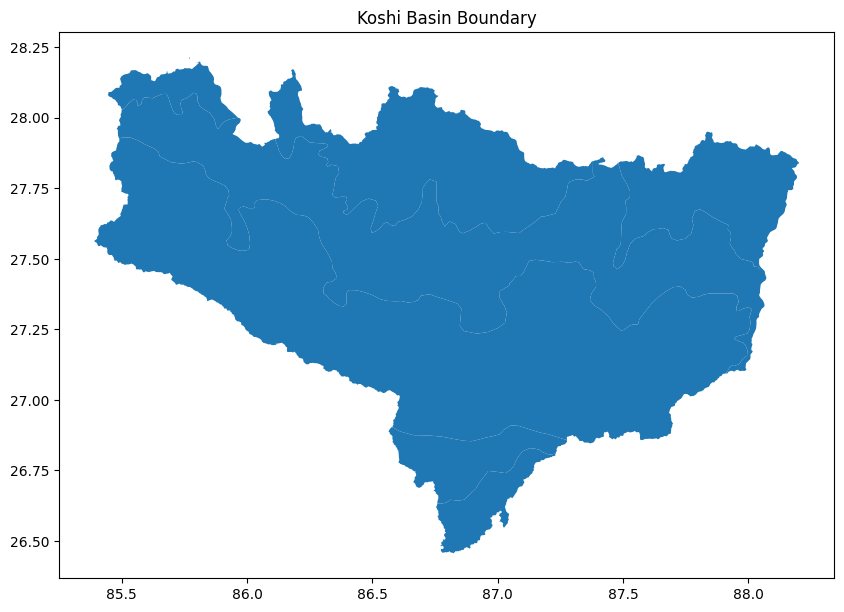

In [4]:
# Plot the Koshi basin boundary
fig, ax = plt.subplots(figsize=(10, 10))
physio_koshi.plot(ax=ax)
ax.set_title('Koshi Basin Boundary')
plt.show()

In [5]:
# Dissolve the Koshi basin to get a single polygon
whole_koshi_basin = physio_koshi.dissolve()

# Convert to Earth Engine feature collection
ee_koshi_basin = geemap.geopandas_to_ee(whole_koshi_basin)
print("Koshi basin converted to Earth Engine feature collection")

Koshi basin converted to Earth Engine feature collection


In [14]:
# Pour point coordinates (lon, lat)
lon, lat = 86.93058173849101, 26.533420103187844
point = ee.Geometry.Point([lon, lat])

# Load HydroATLAS Level 12 basins
basins = ee.FeatureCollection('WWF/HydroATLAS/v1/Basins/level12')

# Find the starting basin
start_basin = basins.filterBounds(point).first()
start_id = start_basin.getNumber('HYBAS_ID')

# Iterative upstream search
def find_upstream(all_basins, start_id):
    ids_to_check = ee.List([start_id])
    all_ids = ee.List([start_id])

    def loop_function(_, loop_data):
        loop_data = ee.Dictionary(loop_data)
        ids_to_check = ee.List(loop_data.get('ids_to_check'))
        all_ids = ee.List(loop_data.get('all_ids'))

        upstream = all_basins.filter(ee.Filter.inList('NEXT_DOWN', ids_to_check))
        new_ids = upstream.aggregate_array('HYBAS_ID').distinct().removeAll(all_ids)

        return ee.Dictionary({
            'ids_to_check': new_ids,
            'all_ids': all_ids.cat(new_ids)
        })

    result = ee.Dictionary(ee.List.sequence(0, 50).iterate(loop_function, {
        'ids_to_check': ids_to_check,
        'all_ids': all_ids
    }))

    return all_basins.filter(ee.Filter.inList('HYBAS_ID', result.get('all_ids')))

# Get all upstream basins
all_upstream_basins = find_upstream(basins, start_id)

# ---- Visualization in folium ---- #
# Convert EE layers to map tiles
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Create base map
center = point.coordinates().getInfo()[::-1]  # lat, lon
m = folium.Map(location=center, zoom_start=9)

# Add DEM
dem = ee.Image('NASA/NASADEM_HGT/001').select('elevation')
m.add_ee_layer(dem, {'min':0, 'max':4000, 'palette':['blue','green','brown','white']}, 'DEM')

# Style and add upstream basins
styled_basins = all_upstream_basins.style(color='blue', fillColor='00000000', width=2)
m.add_ee_layer(styled_basins, {}, 'Upstream Basins')

# Add pour point
folium.Marker(location=center, popup="Pour Point", icon=folium.Icon(color='red')).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Show map
m.save("upstream_basins_map.html")
print("Map saved to 'upstream_basins_map.html'. Open it in your browser.")

NameError: name 'folium' is not defined

## 4. Watershed Delineation using HydroSHEDS and HydroATLAS

We'll use multiple levels of HydroATLAS to get more detailed watershed boundaries.

In [6]:
# Define the point of interest (Chatara dam)
chatara_dam = ee.Geometry.Point([87.165, 26.732])

# Load HydroATLAS datasets at different levels for comparison
hydroatlas_level05 = ee.FeatureCollection("WWF/HydroATLAS/v1/Basins/level05")
hydroatlas_level07 = ee.FeatureCollection("WWF/HydroATLAS/v1/Basins/level07")
hydroatlas_level08 = ee.FeatureCollection("WWF/HydroATLAS/v1/Basins/level08")
hydroatlas_level09 = ee.FeatureCollection("WWF/HydroATLAS/v1/Basins/level09")
hydroatlas_level12 = ee.FeatureCollection("WWF/HydroATLAS/v1/Basins/level12")

In [7]:
# Function to get the basin containing a point
def get_basin_at_point(hydroatlas, point):
    return hydroatlas.filterBounds(point).first()

# Function to get all upstream basins
def get_upstream_basins(hydroatlas, start_basin, max_iterations=100):
    # Create a list of numbers to iterate over on the server side
    iteration_list = ee.List.sequence(1, max_iterations)
    
    # Define the initial state (the starting basin)
    initial_collection = ee.FeatureCollection([start_basin])
    
    # The function to be applied at each iteration
    def iterate_body(number, current_collection):
        current_collection = ee.FeatureCollection(current_collection)
        
        # Get the IDs of the current basins
        basin_ids = current_collection.aggregate_array('HYBAS_ID')
        
        # Find all basins whose 'NEXT_DOWN' ID is in our current collection
        upstream_features = hydroatlas.filter(ee.Filter.inList('NEXT_DOWN', basin_ids))
        
        # Merge the new basins into the collection
        return current_collection.merge(upstream_features)
    
    # Run the iterate function and get the final collection
    result_collection = ee.FeatureCollection(
        iteration_list.iterate(iterate_body, initial_collection)
    )
    
    return result_collection

In [8]:
# Get the basin containing Chatara dam at different levels
basin_level07 = get_basin_at_point(hydroatlas_level07, chatara_dam)
basin_level08 = get_basin_at_point(hydroatlas_level08, chatara_dam)
basin_level09 = get_basin_at_point(hydroatlas_level09, chatara_dam)
basin_level12 = get_basin_at_point(hydroatlas_level12, chatara_dam)

# Get all upstream basins at different levels
upstream_level07 = get_upstream_basins(hydroatlas_level07, basin_level07)
upstream_level08 = get_upstream_basins(hydroatlas_level08, basin_level08)
upstream_level09 = get_upstream_basins(hydroatlas_level09, basin_level09)
upstream_level12 = get_upstream_basins(hydroatlas_level12, basin_level12)

## 5. Visualize the Results

In [13]:
# Create a map centered on the Koshi basin
Map = geemap.Map(center=[27.5, 87.5], zoom=8)

# Add the Koshi basin boundary
Map.addLayer(ee_koshi_basin, {'color': 'black'}, 'Koshi Basin Boundary')

# Add the upstream basins at different levels with different colors

Map.addLayer(upstream_level12.style(color='purple', fillColor='purple'), {}, 'Level 12 Basins')

# Add the Chatara dam point
Map.addLayer(chatara_dam, {'color': 'red'}, 'Chatara Dam')

# Center the map on the Koshi basin
Map.centerObject(ee_koshi_basin)

# Display the map
Map

EEException: Computation timed out.

## 6. Compare the Results

Let's compare the number of sub-basins and total area at different levels.

In [ ]:
# Function to get the number of features and total area
def get_collection_info(collection, name):
    # Get the number of features
    count = collection.size().getInfo()
    
    # Get the total area in square kilometers
    area = collection.geometry().area().divide(1000 * 1000).getInfo()
    
    return {'Level': name, 'Sub-basins': count, 'Area (sq km)': area}

# Get information for each level
info_level07 = get_collection_info(upstream_level07, 'Level 07')
info_level08 = get_collection_info(upstream_level08, 'Level 08')
info_level09 = get_collection_info(upstream_level09, 'Level 09')
info_level12 = get_collection_info(upstream_level12, 'Level 12')

# Create a DataFrame to compare the results
comparison_df = pd.DataFrame([info_level07, info_level08, info_level09, info_level12])
comparison_df

## 7. Export the Results

Let's export the most detailed level (Level 12) to GeoJSON and shapefile formats.

In [ ]:
# Export the Level 12 basins to GeoJSON
geojson_filename = 'koshi_basins_level12.geojson'
geemap.ee_to_geojson(upstream_level12, geojson_filename)
print(f"Export of '{geojson_filename}' successful!")

# Convert to GeoDataFrame and export to shapefile
gdf_level12 = gpd.read_file(geojson_filename)
shapefile_filename = 'koshi_basins_level12.shp'
gdf_level12.to_file(shapefile_filename)
print(f"Export of '{shapefile_filename}' successful!")

## 8. Validate the Results

Let's compare the delineated watershed with the original Koshi basin boundary.

In [ ]:
# Load the exported shapefile
delineated_basin = gpd.read_file('koshi_basins_level12.shp')

# Dissolve to get a single polygon
delineated_basin_dissolved = delineated_basin.dissolve()

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 12))
whole_koshi_basin.plot(ax=ax, color='blue', alpha=0.5, label='Original Koshi Basin')
delineated_basin_dissolved.plot(ax=ax, color='red', alpha=0.5, label='Delineated Watershed')
ax.set_title('Comparison of Original Basin and Delineated Watershed')
ax.legend()
plt.show()

In [ ]:
# Calculate the intersection and difference
intersection = gpd.overlay(whole_koshi_basin, delineated_basin_dissolved, how='intersection')
difference_original = gpd.overlay(whole_koshi_basin, delineated_basin_dissolved, how='difference')
difference_delineated = gpd.overlay(delineated_basin_dissolved, whole_koshi_basin, how='difference')

# Calculate areas
area_original = whole_koshi_basin.area.sum() / 1e6  # in sq km
area_delineated = delineated_basin_dissolved.area.sum() / 1e6  # in sq km
area_intersection = intersection.area.sum() / 1e6  # in sq km
area_diff_original = difference_original.area.sum() / 1e6  # in sq km
area_diff_delineated = difference_delineated.area.sum() / 1e6  # in sq km

# Calculate overlap percentage
overlap_percentage = (area_intersection / area_original) * 100

# Print the results
print(f"Original Basin Area: {area_original:.2f} sq km")
print(f"Delineated Watershed Area: {area_delineated:.2f} sq km")
print(f"Intersection Area: {area_intersection:.2f} sq km")
print(f"Area in Original but not in Delineated: {area_diff_original:.2f} sq km")
print(f"Area in Delineated but not in Original: {area_diff_delineated:.2f} sq km")
print(f"Overlap Percentage: {overlap_percentage:.2f}%")

## 9. Conclusion

This notebook has demonstrated an improved approach to delineating the Koshi basin watershed using Google Earth Engine and HydroSHEDS/HydroATLAS datasets. We've compared different levels of detail and validated the results against the original basin boundary.

The Level 12 HydroATLAS provides the most detailed watershed delineation, but the overlap with the original basin boundary should be carefully evaluated. Differences may be due to:

1. Different data sources and methodologies
2. Different resolutions of the underlying DEMs
3. Different definitions of the watershed boundary

For the most accurate watershed delineation, it's recommended to use the highest resolution data available and validate the results with local knowledge and field observations.